## Data Exploration

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt

### General view of the dataset

In [2]:
df = pd.read_csv('spam_1.csv')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

There are `5572` data points and `5` columns: `v1`, `v2`, `Unnamed: 2`,	`Unnamed: 3`, `Unnamed: 4`


#### Drop `Unnamed: 2`,	`Unnamed: 3`, `Unnamed: 4` since they are irrelevant

In [5]:
# delete 3 unnamed columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

#### Rename `v1` to `Category` and `v2` to `Message`

In [6]:
df = df.rename(columns={"v1": "Label", "v2": "Message"})

In [7]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Check for missing values 

In [ ]:
# check null
df.isnull().sum()

#### Check for duplicates

In [8]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(5169, 2)

After dropping duplicates, the dataset goes from `5572` to `5169` rows

## Data preprocessing

### Remove special character

In [10]:
punctuation = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

In [11]:
df["Message"] = df["Message"].apply(lambda text: remove_punctuation(text))
df.head()

,Label,Message
0,ham,Go until jurong point crazy Available only in ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor U c already then say
4,ham,Nah I dont think he goes to usf he lives aroun...


### Remove stopwords

#### Install `nltk` (Natural Language Toolkit) 

In [ ]:
# pip install nltk

In [ ]:
import nltk

nltk.download('stopwords')

#### Function to remove stopwords

In [12]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [13]:
df["Message"] = df["Message"].apply(lambda text: remove_stopwords(text))
df.head()

,Label,Message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah I dont think goes usf lives around though


### Lemmatizing words

In [ ]:
import nltk

nltk.download('wordnet')

#### Function to lemmatize the text

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# pos_text: Part of speech, assign a tag to each token in a document to denote its part of speech

wordnet_map = {"N":  wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    pos_text = pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_text])

In [15]:
df["Message"] = df["Message"].apply(lambda text: lemmatize_words(text))
df.head()

,Label,Message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah I dont think go usf life around though


### Check label's distribution of target vector `Category` to determine whether unbalanced or not

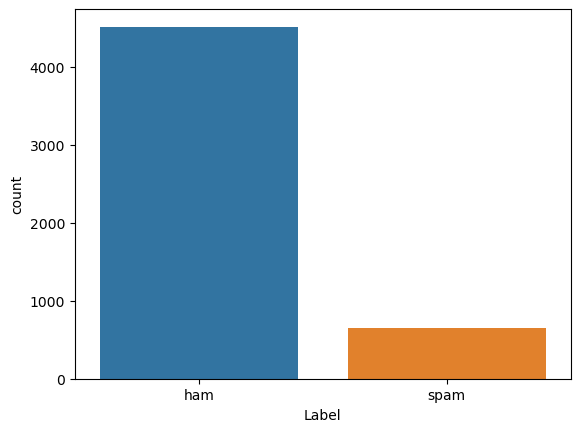

In [16]:
sns.countplot(x="Label", data=df)
plt.savefig('label_count')

In [17]:
df['Label'].value_counts()

Label
ham     4516
spam     653
Name: count, dtype: int64

The labels are unbalanced with **87%** are ham and **13%** are spam

## Split data

In [18]:
X = df['Message']
y = df['Label']

Since there's unbalanced in class lables, **stratified partitioning** will be used because it ensures that every partition preserves the same ratio of values for the prediction target as in the original data

In [19]:
from sklearn.model_selection import train_test_split

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4135,) (1034,) (4135,) (1034,)


## Training models

### Import models from scikit-learn

In [21]:
# base models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# meta model
from sklearn.ensemble import GradientBoostingClassifier

### Initialize TfidfVectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()

### Import  `Kfold`,  `cross_val_score`, `Pipeline`

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### Create pipelines for base models and define baseline performance (training set) with `cross_val_score`

### Pipelines

In [24]:
# initialize LR model
lr = LogisticRegression()
lr_pl = Pipeline([('tf', TfidfVectorizer()), ('lr', lr)]) # initialize LR pipeline 

# initialize KNN model
knn = KNeighborsClassifier()
knn_pl = Pipeline([('tf', TfidfVectorizer()), ('knn', knn)]) # initialize KNN pipeline 

# initialize SVM model
svc = SVC()
svc_pl = Pipeline([('tf', TfidfVectorizer()), ('svc', svc)]) # initialize SVM pipeline 

# initialize NB model
nb = GaussianNB()
nb_pl = Pipeline([('tf', TfidfVectorizer()), ('nb', nb)]) # initialize NB pipeline 

# initialize RF model
rf = RandomForestClassifier()
rf_pl = Pipeline([('tf', TfidfVectorizer()), ('rf', rf)]) # initialize RF pipeline 

# initialize DT model
dt = DecisionTreeClassifier()
dt_pl = Pipeline([('tf', TfidfVectorizer()), ('dt', dt)])  # initialize DT pipeline 


In [25]:
pipelines = [lr_pl, knn_pl, svc_pl, rf_pl, dt_pl]

pipe_dict = {0: 'Logistic Regression', 1: 'K Nearest Neighbor', 2: 'Support Vector Machine',
             3: 'Random Forrest', 4: 'Decision Tree'}

#### Cross validate for all based models except Naive Bayes (due to sparse matrix error)

In [26]:
for i in range(len(pipelines)):
    score = cross_validate(pipelines[i], X_train, y_train,
                          cv=kfold, scoring='accuracy',
                          return_train_score=True)
    print(pipe_dict[i])
    for k, v in score.items():
        print(k, np.mean(v))
    print('\n')

Logistic Regression
fit_time 0.3621193885803223
score_time 0.045862674713134766
test_score 0.9547762998790811
train_score 0.9558645707376059


K Nearest Neighbor
fit_time 0.16872119903564453
score_time 0.6006708145141602
test_score 0.9110036275695285
train_score 0.9167472793228537


Support Vector Machine
fit_time 3.131206750869751
score_time 0.5185811519622803
test_score 0.9724304715840386
train_score 0.9976420798065296


Random Forrest
fit_time 10.724314117431641
score_time 0.1771376132965088
test_score 0.9688029020556227
train_score 1.0


Decision Tree
fit_time 2.3229061126708985
score_time 0.04192805290222168
test_score 0.9400241837968561
train_score 1.0




#### Cross validate for Naive Bayes

In [27]:
# for NB
nb_test = GaussianNB()
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

X_train_tf_arr = X_train_tf.toarray()
X_test_tf_arr = X_test_tf.toarray()

nb_score = cross_validate(nb_test, X_train_tf_arr, y_train,
                          cv=kfold, scoring='accuracy',
                          return_train_score=True)
print('Naive Bayes')
for k, v in nb_score.items():
    print(k, np.mean(v))

Naive Bayes
fit_time 1.092834758758545
score_time 0.3466601848602295
test_score 0.8836759371221282
train_score 0.9530229746070132


### Summary of the model's baseline performances (train_score focus)

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [29]:
# search for LR
lr_param = {'penalty': ["elasticnet"], 
            'solver': ["saga"],
            'l1_ratio': [0.5, 0.7, 0.9]
           }
lr_search = GridSearchCV(lr, lr_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('LR random best score: ', lr_search.best_score_)
print('LR random best param: ', lr_search.best_params_)

LR random best score:  0.9417170495767836
LR random best param:  {'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


In [30]:
# search for KNN
knn_param = {'weights': ['uniform', 'distance'],
             'metric': ['euclidean', 'manhattan'],
             'n_neighbors': [1, 5, 9]
            }
knn_search = GridSearchCV(knn, knn_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('KNN random best score: ', knn_search.best_score_)
print('KNN random best param: ', knn_search.best_params_)

KNN random best score:  0.939782345828295
KNN random best param:  {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


In [31]:
# search for SVM  
svm_param = {'kernel': ['poly', 'rbf', 'sigmoid'],
             'C': [1.0, 0.1, 0.01],
             'gamma': ['scale']
            }
svm_search = GridSearchCV(svc, svm_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('SVM random best score: ', svm_search.best_score_)
print('SVM random best param: ', svm_search.best_params_)

SVM random best score:  0.9721886336154777
SVM random best param:  {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [32]:
# search for RF
rf_param = {'n_estimators': [10, 100, 1000],
           'max_features': ['sqrt', 'log2'],
            'max_depth': [15, 25, 30]
           }
rf_search = RandomizedSearchCV(rf, rf_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('RF random best score: ', rf_search.best_score_)
print('RF random best param: ', rf_search.best_params_)

RF random best score:  0.9530834340991536
RF random best param:  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 30}


In [33]:
# search for DT
dt_param = {'max_depth': [5, 10, 20],
            'min_samples_leaf': [20, 50, 100],
            'criterion': ["gini", "entropy"]
           }
dt_search = GridSearchCV(dt, dt_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('DT random best score: ', dt_search.best_score_)
print('DT random best param: ', dt_search.best_params_)

DT random best score:  0.935912938331318
DT random best param:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20}


In [34]:
# search for NB
nb_param = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_search = RandomizedSearchCV(nb, nb_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf_arr, y_train)
print('NB random best score: ', nb_search.best_score_)
print('NB random best param: ', nb_search.best_params_)

NB random best score:  0.9201934703748489
NB random best param:  {'var_smoothing': 0.01519911082952933}


### Get out-of-fold predictions for each tuned model

In [35]:
# out-of-fold portion
# return full_y_pred, full_holdout_pred

def out_of_fold(model, X_train_tf, X_test_tf, y_train, y_test, kfold):
    # initialize arrays to store predictions
    full_y_pred = np.empty((0,))
    full_holdout_pred = np.zeros(len(X_test_tf))
    
    y_train_text = np.array(y_train)
    
    # create out-of-fold predictions for model stacking
    for fold, (train_index, test_index) in enumerate(kfold.split(X_train_tf)):
        X_train_fold, X_test_fold = X_train_tf[train_index], X_train_tf[test_index]
        y_train_fold, y_test_fold = y_train_text[train_index], y_train_text[test_index]
        
        # fit model
        model.fit(X_train_fold, y_train_fold)

        # make predictions on fold test and test sets
        y_fold_pred = model.predict_proba(X_test_fold)[:, 1]
        holdout_pred = model.predict_proba(X_test_tf)[:, 1]


        # extend full_y_pred with fold predictions
        full_y_pred = np.concatenate((full_y_pred, y_fold_pred))
        full_holdout_pred += holdout_pred
        
    print('full_y_pred', len(full_y_pred), full_y_pred)
    
    print('full_holdout_pred', len(full_holdout_pred), full_holdout_pred)
    
    return (full_y_pred, full_holdout_pred)

In [36]:
# tuned LR
lr_best = lr_search.best_params_
tuned_lr = LogisticRegression(**lr_best)

# lr oof
full_lr, holdout_lr = out_of_fold(tuned_lr, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_lr, holdout_lr)

full_y_pred 4135 [0.0289901  0.05273896 0.25910516 ... 0.05279427 0.04657814 0.05279427]
full_holdout_pred 1034 [0.27249189 0.24179538 0.16562685 ... 4.61499161 0.1817328  0.19305768]
[0.0289901  0.05273896 0.25910516 ... 0.05279427 0.04657814 0.05279427] [0.27249189 0.24179538 0.16562685 ... 4.61499161 0.1817328  0.19305768]


In [37]:
# tuned KNN
knn_best = knn_search.best_params_
tuned_knn = KNeighborsClassifier(**knn_best)

# knn oof
full_knn, holdout_knn = out_of_fold(tuned_knn, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_knn, holdout_knn)

full_y_pred 4135 [0.         0.         0.13610728 ... 0.         0.         0.        ]
full_holdout_pred 1034 [0.         0.         0.         ... 3.54673278 0.         0.        ]
[0.         0.         0.13610728 ... 0.         0.         0.        ] [0.         0.         0.         ... 3.54673278 0.         0.        ]


In [38]:
# tuned SVC
svm_best = svm_search.best_params_
tuned_svc = SVC(**svm_best, probability=True)

# svm oof
full_svm, holdout_svm = out_of_fold(tuned_svc, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_svm, holdout_svm)

full_y_pred 4135 [1.49470653e-04 3.75364629e-02 9.49508467e-01 ... 5.77411286e-02
 1.48072200e-02 8.55870186e-02]
full_holdout_pred 1034 [7.85992640e-03 1.84135637e-03 9.72956997e-03 ... 4.99999999e+00
 5.52011889e-02 6.40194210e-02]
[1.49470653e-04 3.75364629e-02 9.49508467e-01 ... 5.77411286e-02
 1.48072200e-02 8.55870186e-02] [7.85992640e-03 1.84135637e-03 9.72956997e-03 ... 4.99999999e+00
 5.52011889e-02 6.40194210e-02]


In [39]:
# tuned RF
rf_best = rf_search.best_params_
tuned_rf = RandomForestClassifier(**rf_best)

# RF oof
full_rf, holdout_rf = out_of_fold(tuned_rf, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_rf, holdout_rf)

full_y_pred 4135 [0.03305323 0.06211294 0.50207698 ... 0.03294296 0.03294296 0.05196546]
full_holdout_pred 1034 [0.17809174 0.15976944 0.16142146 ... 4.58897612 0.27184692 0.16784778]
[0.03305323 0.06211294 0.50207698 ... 0.03294296 0.03294296 0.05196546] [0.17809174 0.15976944 0.16142146 ... 4.58897612 0.27184692 0.16784778]


In [40]:
# tuned RF
dt_best = dt_search.best_params_
tuned_dt = DecisionTreeClassifier(**dt_best)

# RF oof
full_dt, holdout_dt = out_of_fold(tuned_dt, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_dt, holdout_dt)

full_y_pred 4135 [0.02723881 0.02723881 0.22641509 ... 0.02769461 0.02769461 0.02769461]
full_holdout_pred 1034 [0.13835223 0.13835223 0.13835223 ... 4.45998168 0.13835223 0.13835223]
[0.02723881 0.02723881 0.22641509 ... 0.02769461 0.02769461 0.02769461] [0.13835223 0.13835223 0.13835223 ... 4.45998168 0.13835223 0.13835223]


In [41]:
# tuned NB
nb_best = nb_search.best_params_
tuned_nb = GaussianNB(**nb_best)

# RF oof
full_nb, holdout_nb = out_of_fold(tuned_nb, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_nb, holdout_nb)

full_y_pred 4135 [0.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.10998646e-253
 0.00000000e+000 7.27251969e-001]
full_holdout_pred 1034 [0. 0. 0. ... 5. 0. 0.]
[0.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.10998646e-253
 0.00000000e+000 7.27251969e-001] [0. 0. 0. ... 5. 0. 0.]


### Stack models' predictions to make a new training data for meta class 

In [42]:
stack_train = np.column_stack((full_lr, full_knn, full_svm, full_rf, full_dt, full_nb))
stack_test = np.column_stack((holdout_lr, holdout_knn, holdout_svm, holdout_rf, holdout_dt, holdout_nb))

In [43]:
stack_train_df = pd.DataFrame(stack_train)
stack_train_df

,0,1,2,3,4,5
0,0.028990,0.000000,0.000149,0.033053,0.027239,0.000000e+00
1,0.052739,0.000000,0.037536,0.062113,0.027239,1.000000e+00
2,0.259105,0.136107,0.949508,0.502077,0.226415,1.000000e+00
3,0.027980,0.000000,0.000704,0.034543,0.027239,0.000000e+00
4,0.031561,0.000000,0.000161,0.032836,0.027239,0.000000e+00
...,...,...,...,...,...,...
4130,0.018411,0.000000,0.000173,0.032943,0.027695,0.000000e+00
4131,0.216386,0.304534,0.727467,0.407936,0.707317,1.000000e+00
4132,0.052794,0.000000,0.057741,0.032943,0.027695,1.109986e-253
4133,0.046578,0.000000,0.014807,0.032943,0.027695,0.000000e+00


In [44]:
stack_test_df = pd.DataFrame(stack_test)
stack_test_df

,0,1,2,3,4,5
0,0.272492,0.000000,0.007860,0.178092,0.138352,0.0
1,0.241795,0.000000,0.001841,0.159769,0.138352,0.0
2,0.165627,0.000000,0.009730,0.161421,0.138352,0.0
3,0.209849,0.000000,0.038478,0.159865,0.138352,0.0
4,0.210652,0.000000,0.006742,0.159769,0.138352,0.0
...,...,...,...,...,...,...
1029,4.329394,1.210303,4.976182,2.153712,3.300000,5.0
1030,0.266277,0.000000,0.059382,0.159769,0.138352,0.0
1031,4.614992,3.546733,5.000000,4.588976,4.459982,5.0
1032,0.181733,0.000000,0.055201,0.271847,0.138352,0.0


### Cross val score with meta model

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

meta_model = GradientBoostingClassifier(learning_rate=0.02, n_estimators=1100, n_iter_no_change=100, random_state=42)

cv_score = cross_val_score(meta_model, stack_train_df, y_train, cv=kfold, scoring="accuracy")
print("Meta mean accuracy", np.mean(cv_score))

Meta mean accuracy 0.8732769044740024


### Tuned meta model

In [47]:
meta_param = {'max_depth': [4, 6, 8], 
             'subsample': [0.5, 0.75, 1.0], 
             'min_samples_leaf': [50, 60, 70]}

meta_grid = GridSearchCV(meta_model, meta_param, cv=kfold, scoring="accuracy", n_jobs=-1).fit(stack_train_df, y_train)

print('Meta grid best score: ', meta_grid.best_score_)
print('Meta grid best param: ', meta_grid.best_params_)

Meta grid best score:  0.8737605804111246
Meta grid best param:  {'max_depth': 4, 'min_samples_leaf': 50, 'subsample': 0.5}


### Import metrics

In [96]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [94]:
# from sklearn.metrics import precision_recall_curve

# lr_proba = tuned_lr.predict_proba(X_test_tf)[:, 1]

# precision, recall, thresholds = precision_recall_curve(y_test, lr_proba)
# precision

### Meta model on test set

In [48]:
meta_best = meta_grid.best_params_

final_meta = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000, 
                                        n_iter_no_change=100, random_state=42,
                                       **meta_best)

# evaluate on test set
final_meta.fit(stack_train_df, y_train)
y_pred = final_meta.predict(stack_test_df)
final_acc = accuracy_score(y_test, y_pred)
final_acc

0.8733075435203095

### Helper function to evaluate each model on test set

In [105]:
def evaluate(models, X_train_tf, X_test_tf, y_train, y_test):
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores =  []
    
    for model in models:
        model.fit(X_train_tf, y_train)
        model_pred = model.predict(X_test_tf)
        
        model_acc = accuracy_score(y_test, model_pred)
        model_prec = precision_score(y_test, model_pred, pos_label="spam")
        model_rec = recall_score(y_test, model_pred, pos_label="spam")
        model_f1 = f1_score(y_test, model_pred, pos_label="spam")
        
        acc_scores.append(model_acc)
        prec_scores.append(model_prec)
        rec_scores.append(model_rec)
        f1_scores.append(model_f1)
        
        
    for i in range(len(models)):
        print(pipe_dict[i], 'accuracy:', acc_scores[i])
        print(pipe_dict[i], 'precision:', prec_scores[i])
        print(pipe_dict[i], 'recall:', rec_scores[i])
        print(pipe_dict[i], 'f1:', f1_scores[i])
        
    return (acc_scores, prec_scores, rec_scores, f1_scores)

In [109]:
def nb_evaluate(model, X_train_tf_arr, X_test_tf_arr, y_train, y_test):
    # fit model
    model.fit(X_train_tf_arr, y_train)
    model_pred = model.predict(X_test_tf_arr)
    
    # get accuracy score
    model_acc = accuracy_score(y_test, model_pred)
    model_prec = precision_score(y_test, model_pred, pos_label="spam")
    model_rec = recall_score(y_test, model_pred, pos_label="spam")
    model_f1 = f1_score(y_test, model_pred, pos_label="spam")
    
    print("Naive Bayes accuracy" ':', model_acc)
    print("Naive Bayes precision" ':', model_prec)
    print("Naive Bayes recall" ':', model_rec)
    print("Naive Bayes f1" ':', model_f1)
    
    return (model_acc, model_prec, model_rec, model_f1)

### Tuned models on test set: accuracy, precision, recall, F1 scores

In [106]:
tuned_models = [tuned_lr, tuned_knn, tuned_svc, tuned_rf, tuned_dt]

tuned_scores = evaluate(tuned_models, X_train_tf, X_test_tf, y_train, y_test)

Logistic Regression accuracy: 0.9593810444874274
Logistic Regression precision: 0.968421052631579
Logistic Regression recall: 0.7022900763358778
Logistic Regression f1: 0.8141592920353982
K Nearest Neighbor accuracy: 0.9390715667311412
K Nearest Neighbor precision: 1.0
K Nearest Neighbor recall: 0.5190839694656488
K Nearest Neighbor f1: 0.6834170854271356
Support Vector Machine accuracy: 0.9816247582205029
Support Vector Machine precision: 0.9912280701754386
Support Vector Machine recall: 0.8625954198473282
Support Vector Machine f1: 0.9224489795918368
Random Forrest accuracy: 0.960348162475822
Random Forrest precision: 1.0
Random Forrest recall: 0.6870229007633588
Random Forrest f1: 0.8144796380090498
Decision Tree accuracy: 0.9158607350096711
Decision Tree precision: 0.782051282051282
Decision Tree recall: 0.46564885496183206
Decision Tree f1: 0.5837320574162679


In [110]:
nb_score = nb_evaluate(tuned_nb, X_train_tf_arr, X_test_tf_arr, y_train, y_test)

Naive Bayes accuracy: 0.9526112185686654
Naive Bayes precision: 0.7383720930232558
Naive Bayes recall: 0.9694656488549618
Naive Bayes f1: 0.8382838283828382


### ROC AUC on test set

### Base models on test set

In [111]:
base_models = [lr, knn, svc, rf, dt]

base_scores = evaluate(base_models, X_train_tf, X_test_tf, y_train, y_test)

Logistic Regression accuracy: 0.9584139264990329
Logistic Regression precision: 1.0
Logistic Regression recall: 0.6717557251908397
Logistic Regression f1: 0.8036529680365296
K Nearest Neighbor accuracy: 0.902321083172147
K Nearest Neighbor precision: 1.0
K Nearest Neighbor recall: 0.22900763358778625
K Nearest Neighbor f1: 0.37267080745341613
Support Vector Machine accuracy: 0.9787234042553191
Support Vector Machine precision: 1.0
Support Vector Machine recall: 0.8320610687022901
Support Vector Machine f1: 0.9083333333333334
Random Forrest accuracy: 0.9729206963249516
Random Forrest precision: 0.9904761904761905
Random Forrest recall: 0.7938931297709924
Random Forrest f1: 0.8813559322033899
Decision Tree accuracy: 0.9458413926499033
Decision Tree precision: 0.7862595419847328
Decision Tree recall: 0.7862595419847328
Decision Tree f1: 0.7862595419847328


In [112]:
nb_base_score = nb_evaluate(nb, X_train_tf_arr, X_test_tf_arr, y_train, y_test)


Naive Bayes accuracy: 0.8762088974854932
Naive Bayes precision: 0.5069124423963134
Naive Bayes recall: 0.8396946564885496
Naive Bayes f1: 0.632183908045977


# Metrics used: accuracy, precision, recall, F1 score, ROC AUC, confusion matrix

## Evaluate where models don't do good

In [ ]:
# boom


## Comparison 

### Tuned models with Meta model

In [79]:
tuned_acc_plot = ["Logistic Regression", "K-nearest neighbors", 
                  "Support Vector Machine", "Random Forest", 
                  "Decision Tree", "Naive Bayes", "Gradient Boosting Classifier"]
acc_data = []
for t in tuned_scores:
    acc_data.append(t)
    
acc_data.append(nb_score)
acc_data.append(final_acc)

In [80]:
acc_data

[0.9593810444874274,
 0.9390715667311412,
 0.9816247582205029,
 0.9555125725338491,
 0.9158607350096711,
 0.9526112185686654,
 0.8733075435203095]

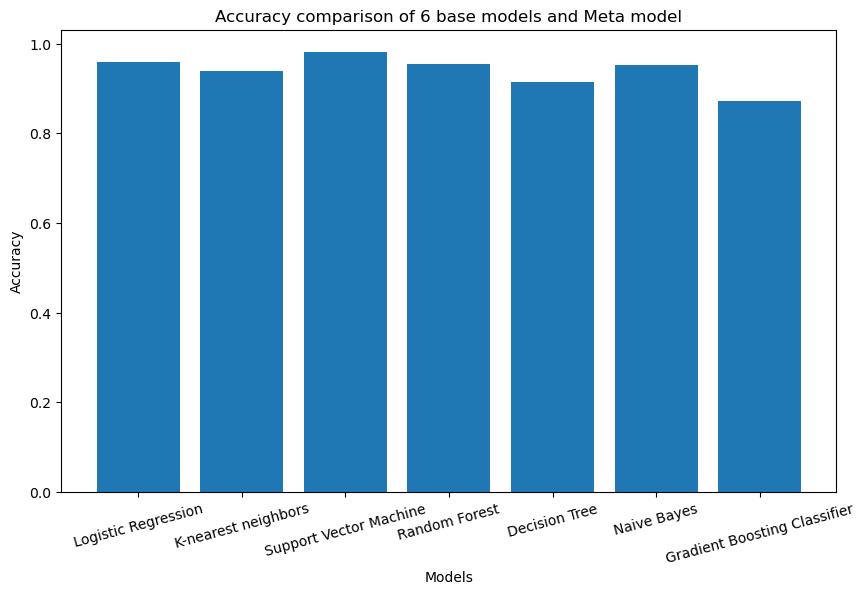

In [88]:
# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(tuned_acc_plot, acc_data) 

# Customize the plot
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison of 6 base models and Meta model")
plt.xticks(rotation=15)  # Rotate x-axis labels for readability if many models
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Display the plot
plt.show()

### Base models